<a name="top"></a>
#  DDACTS for Public Safety
## Using Machine Learning to Model Crime


### Chris Ruiz<br>cruiz@uwyo.edu
### University of Wyoming<br>Spring 2018<br>COSC 4570 - Data Mining
### https://github.com/larf-io/DDACTS2018

***
## Table of Contents
***

* [Data-Driven Approaches to Crime and Traffic Safety](#ddacts)
* [Loading the Data](#loadingTheData)
* [Initial Exploration and Pre-processing of the Data](#initialExploration)
  * [Checking for NA's](#checkingForNas)
  * [Correcting Odd Latitude/Longitude Values](#correctingOddLatLong)
  * [Analyzing Unique Values](#analyzingUniqueValues)
  * [Adding Columns to the Data](#addingColumns)
* [Generating a Basic Heat Map](#heatMap)
* [Machine Learning to Predict Crime](#machineLearning)
* [Conclusions](#conclusions)
  
<a name="ddacts"></a>
***
## Data-Driven Approaches to Crime and Traffic Safety
***
The U.S. National Highway Traffic Safety Administration, in conjunction with the Bureau of Justice Assistance and the National Institute of Justice, created the Data-Driven Approaches to Crime and Traffic Safety (DDACTS) guidelines as a method of reducing crime and traffic incidents. Currently I work for the City of Laramie IT Division, so naturally I consulted with the City's Public Safety Answering Point (PSAP) Administrator, Steven Morgan. Steven and I had a conversation about some of the crime information that would be beneficial to him as a PSAP administrator in increasing public safety; he then directed me towards the  DDACTS guidelines for further reading. I decided to use DDACTS as an inspiration for this project.

DDACTS lays out guidelines describing the type of crime data that should be collected, who should collect it, how often it should be collected, etc. It also mentions some facets of analysis that would be beneficial to a public safety organization. I honed in on one of those guidelines for DDACTS, which specified that an organization should capture data and be able to accurately predict the type of crime that happens at a given location and time. I felt that this would be a great application of machine learning, and thus this project was born.

[back to top](#top)

<a name="loadingTheData"></a>
***
## Loading the Data
***
I begin by importing all of the tools that I need for analysis.

In [1]:
import pandas as pd
import numpy as np

import holoviews as hv
from holoviews.operation import decimate
from holoviews.operation.datashader import aggregate, datashade, dynspread, shade

from bokeh.models import WMTSTileSource
from bokeh.palettes import viridis

import geoviews as gv

import datashader as ds
import datashader.transfer_functions as tf

from datetime import datetime

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

* `pandas` allows for storage of data in "data frame" containers, which make data processing much easier
* `numpy` is the Python standard for mathematical operations
* `holoviews` is a wrapper around the `bokeh` mapping backend, which will used for mapping the data
  * We also will include the `bokeh.modules` and `bokeh.palettes` packages from `bokeh` 
* `datashader` allows plotting of a large number of data points without breaking the web browser
* `datetime` becomes necessary for converting date/time data for use by the machine learning models
* `sklearn` (scikit-learn) contains the tools needed for machine learning operations

Here, I set some global variables relating to the data used for analysis.

In [2]:
DATA_URL = "https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv"
LOCAL_DATA_ZIP = "Crimes_-_2001_to_present.zip"

I also configure the `holoviews`/`bokeh` backend for use.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
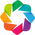

In [3]:
# set presets for modules
hv.extension('bokeh')
decimate.max_samples=10000
dynspread.max_px=40
dynspread.threshold=0.5
shade.cmap="#30a2da"
%opts Overlay [width=900 height=525 xaxis=None yaxis=None]

I start the analysis by importing the raw data. I decided to use the zipped file (included as a download, link in the GitHub repository) for reproducibility (the data is updated multiple times, daily, so slight deviations from what you read here may occur if the dataset varies).

In [4]:
data = pd.read_csv(LOCAL_DATA_ZIP,compression='zip')

If you are feeling brave and would like to download the latest copy of the data, uncomment and run the following cell.

In [5]:
#data = pd.read_csv(DATA_URL)

[back to top](#top)

<a name="initialExploration"></a>
***
## Initial Exploration and Pre-processing of the Data
***

With the data loaded, I first check how much data I'm actually dealing with.

In [6]:
shape = data.shape
print("Data consists of " + str(shape[0]) + " rows and " + str(shape[1]) + " columns.")

Data consists of 6576912 rows and 22 columns.


An initial look at the data reveals quite a few data points. Challenge accepted.  

I then preview the first three rows of the data to get a feel for what's in store.

In [7]:
print("- Example data -")
print(data.loc[1:3])

- Example data -
         ID Case Number                    Date                   Block  IUCR  \
1  10000094    HY190059  03/18/2015 11:00:00 PM  066XX S MARSHFIELD AVE  4625   
2  10000095    HY190052  03/18/2015 10:45:00 PM   044XX S LAKE PARK AVE  0486   
3  10000096    HY190054  03/18/2015 10:30:00 PM    051XX S MICHIGAN AVE  0460   

    Primary Type              Description Location Description  Arrest  \
1  OTHER OFFENSE         PAROLE VIOLATION               STREET    True   
2        BATTERY  DOMESTIC BATTERY SIMPLE            APARTMENT   False   
3        BATTERY                   SIMPLE            APARTMENT   False   

   Domestic              ...                Ward  Community Area  FBI Code  \
1     False              ...                15.0            67.0        26   
2      True              ...                 4.0            39.0       08B   
3     False              ...                 3.0            40.0       08B   

   X Coordinate Y Coordinate  Year              

[back to top](#top)
<a name="checkingForNas"></a>
### Checking for NA's

Before I get too far into exploration of the data, I decide to check for the presence of NA (missing) values. I mark columns with NA values present as "true" so I can see what kind of information is missing.

In [8]:
print ("- Presence of NA -")
for col in np.sort(data.columns.values):
    print("[" + col + "]: " + str(any(pd.isnull(data[col]))))

- Presence of NA -
[Arrest]: False
[Beat]: False
[Block]: False
[Case Number]: True
[Community Area]: True
[Date]: False
[Description]: False
[District]: True
[Domestic]: False
[FBI Code]: False
[ID]: False
[IUCR]: False
[Latitude]: True
[Location]: True
[Location Description]: True
[Longitude]: True
[Primary Type]: False
[Updated On]: False
[Ward]: True
[X Coordinate]: True
[Y Coordinate]: True
[Year]: False


I will definitely need to exclude rows where the data does not contain X/Y and latitude/longitude values if I intend to map the data. Additionally, because I have so much data, I feel comfortable with eliminating any rows with missing values as long as I retain a decent amount of data afterwards. To do so, I can just use `pandas` to drop rows with values of NA.

In [9]:
data = data.dropna(axis=0)

Now, I verify that the NA values have been eliminated.

In [10]:
print ("- Presence of NA, post-drop -")
for col in np.sort(data.columns.values):
    print("[" + col + "]: " + str(any(pd.isnull(data[col]))))

- Presence of NA, post-drop -
[Arrest]: False
[Beat]: False
[Block]: False
[Case Number]: False
[Community Area]: False
[Date]: False
[Description]: False
[District]: False
[Domestic]: False
[FBI Code]: False
[ID]: False
[IUCR]: False
[Latitude]: False
[Location]: False
[Location Description]: False
[Longitude]: False
[Primary Type]: False
[Updated On]: False
[Ward]: False
[X Coordinate]: False
[Y Coordinate]: False
[Year]: False


I also feel at this point that I should verify that there are still have enough rows to proceed and that all columns have been retained by the previous operation.

In [11]:
shape2 = data.shape
print("Data now consists of " + str(shape[0]) + " rows and " + str(shape[1]) + " columns.\n")
print("We have dropped " + str(shape[0]-shape2[0]) + " rows and " + str(shape[1]-shape2[1]) + " columns.")

Data now consists of 6576912 rows and 22 columns.

We have dropped 668262 rows and 0 columns.


No columns dropped, and I'd say that 6.5+ million data points counts as "enough" data. :)

[back to top](#top)

<a name="correctingOddLatLong"></a>
### Correcting Odd Latitude/Longitude Values

This step admittedly happened out of order from where you are reading it, but this is the most logical place to perform it. At this point, I decide to validate that latitude and longitude values are clustered around Chicago.

In [12]:
hist_lat = np.histogram(data['Latitude'].values)
print(hist_lat)

(array([    107,       0,       0,       0,       0,       0,       0,
             0,       0, 5908543], dtype=int64), array([36.61944639, 37.15977272, 37.70009904, 38.24042536, 38.78075169,
       39.32107801, 39.86140433, 40.40173066, 40.94205698, 41.4823833 ,
       42.02270962]))


It appears that there are 107 values of latitude fall quite a bit away from where they would be expected to fall. I try to see if I can figure out where those are:

In [13]:
bad_lat = data[data['Latitude'] < hist_lat[1][1]]['Latitude'].unique()
print (bad_lat)

[36.61944639]


Lo and behold, there is only one unique value of latitude.

Of course, I feel at this point that I should also check longitude.

In [14]:
hist_lon = np.histogram(data['Longitude'].values)
print(hist_lon)

(array([    107,       0,       0,       0,       0,       0,       0,
             0,       0, 5908543], dtype=int64), array([-91.68656568, -91.27036205, -90.85415842, -90.43795479,
       -90.02175116, -89.60554753, -89.1893439 , -88.77314027,
       -88.35693664, -87.94073301, -87.52452938]))


In [15]:
bad_lon = data[data['Longitude'] < hist_lon[1][1]]['Longitude'].unique()
print(bad_lon)

[-91.68656568]


Again, there are 107 values that are suspect. This means that I seem to have only one coordinate that is not located near the rest of our coordinates. I have evidence that it would be appropriate to eliminate these odd points from analysis, so I do so.

In [16]:
data = data[(data['Latitude'].values != bad_lat) & (data['Longitude'].values != bad_lon)]

I do a quick check to see how many values were eliminated just to be safe.

In [17]:
shape3 = data.shape
print("Data now consists of " + str(shape[0]) + " rows and " + str(shape[1]) + " columns.\n")
print("We have dropped " + str(shape2[0]-shape3[0]) + " rows and " + str(shape2[1]-shape3[1]) + " columns.")

Data now consists of 6576912 rows and 22 columns.

We have dropped 107 rows and 0 columns.


[back to top](#top)

<a name="analyzingUniqueValues"></a>
### Analyzing Unique Values

Though it's good to see what the data looks like at a glance, I feel like we can get more information from an analysis of its unique values.

Here, I print the counts of unique values of the data, and if there are counts less than 40 (arbitrarily chosen for my curiosity, my sanity, and your readability), I print all of those values.

In [18]:
print ("- Unique values -")
for col in np.sort(data.columns.values):
    u = data[col].unique()
    l = len(u)
    print("[" + col + "]")
    print("  Count: " + str(l))
    print("  Type: " + str(u.dtype))
    if l < 40:
        print("  Values: ",end='')
        print(np.sort(u))
    print()

- Unique values -
[Arrest]
  Count: 2
  Type: bool
  Values: [False  True]

[Beat]
  Count: 303
  Type: int64

[Block]
  Count: 34786
  Type: object

[Case Number]
  Count: 5908178
  Type: object

[Community Area]
  Count: 78
  Type: float64

[Date]
  Count: 2358148
  Type: object

[Description]
  Count: 377
  Type: object

[District]
  Count: 24
  Type: float64
  Values: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 24. 25. 31.]

[Domestic]
  Count: 2
  Type: bool
  Values: [False  True]

[FBI Code]
  Count: 26
  Type: object
  Values: ['01A' '01B' '02' '03' '04A' '04B' '05' '06' '07' '08A' '08B' '09' '10'
 '11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '22' '24' '26']

[ID]
  Count: 5908543
  Type: int64

[IUCR]
  Count: 399
  Type: object

[Latitude]
  Count: 635465
  Type: float64

[Location]
  Count: 636071
  Type: object

[Location Description]
  Count: 176
  Type: object

[Longitude]
  Count: 635109
  Type: float64

[Primary Type]
  Cou

From the exploration of unique values, I can make several observations:
1. ID does not uniquely identify a row (unique value count does not equal the number of rows in the data). In fact, no single category does.
2. Unique latitude/longitude counts do not equal unique X and Y coordinate counts. This leads me to suspect that the presense of more latitude/longitude values may mean that those values are more specific than their X/Y counterparts, making them more precise for mapping.
3. With the relatively low amount of unique districts present, it would be reasonable to discuss analysis with respect to each district. Districts should be easy to map too.
4. I'm not sure what the difference between Primary Type "NON - CRIMINAL" and "NON-CRIMINAL" is. Perhaps a data entry issue? Just in case, I won't mess with this one.

[back to top](#top)

<a name="addingColumns"></a>
### Adding Columns to the Data

If you can't already tell, I enjoy numbers a bit too much. At this point of the project, I feel like this needs at least one graphic. I also see the machine learning tasks looming on the horizon. 

Through some rather painful troubleshooting, I would come to find out that it would be best to create a "Label" column representing a numeric coding of the types of crime. This column would be accepted nicely by the machine learning classification algorithms I would end up using. This step happened out of order, but it makes sense to describe the steps now.

I create a LabelEncoder object that will handle the coding for me.

In [19]:
le = LabelEncoder()
le.fit(data['Primary Type'].values)

LabelEncoder()

Then, I transform the Primary Type data using the LabelEncoder and add it to a new column of the data called Label.

In [20]:
data['Label'] = data[['Primary Type']].apply(lambda x: le.transform(x))

For processing, I also learn that it is beneficial to transform the data's Date strings to DateTime objects. Further, I would change those DateTime objects to floats so the machine learning models accepted them without too much fuss.

In [21]:
data['DateTime'] = data['Date'].apply(lambda x: datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p').timestamp())

[back to top](#top)

<a name="heatMap"></a>
***
## Generating a Basic Heat Map
***
    
Now, it's graphic time! One of my analysis questions was whether there existed any hotspots of crime data, so this plot would hopefully show those hotspots.

In [22]:
tiles = gv.WMTS(WMTSTileSource(url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{Z}/{Y}/{X}.jpg'))
points = gv.Points(gv.Dataset(data, kdims=['Longitude', 'Latitude'], vdims=['Label']),label="Points")
data_pointplot = datashade(points,element_type=gv.Image,cmap=viridis(len(data['Label'].unique())))
tiles * data_pointplot

:DynamicMap   []
   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .RGB.Points :RGB   [Longitude,Latitude]   (R,G,B,A)

This graphic clearly shows some clustering of crime types in certain locations.

To determine which crime counts are the highest, I measure the unique number of crimes in the Primary Type column:

In [23]:
data['Primary Type'].value_counts()

THEFT                                1239674
BATTERY                              1077826
CRIMINAL DAMAGE                       679184
NARCOTICS                             627533
OTHER OFFENSE                         365813
ASSAULT                               364207
BURGLARY                              346667
MOTOR VEHICLE THEFT                   272740
ROBBERY                               225395
DECEPTIVE PRACTICE                    222591
CRIMINAL TRESPASS                     170984
WEAPONS VIOLATION                      61199
PROSTITUTION                           59310
PUBLIC PEACE VIOLATION                 43321
OFFENSE INVOLVING CHILDREN             39207
CRIM SEXUAL ASSAULT                    22695
SEX OFFENSE                            20679
INTERFERENCE WITH PUBLIC OFFICER       13742
GAMBLING                               13029
LIQUOR LAW VIOLATION                   11766
ARSON                                   9531
HOMICIDE                                8559
KIDNAPPING

[back to top](#top)

<a name="machineLearning"></a>
***
## Machine Learning to Predict Crime
***
    
Now for the fun part. I mention that I used two machine learning methods (Multi Layer Perceptron Classifier and Bernoulli Naive Bayes) in my project poster; with some extra time, I added K-Nearest Neighbor Classifier and Random Forest Classifier models in order to supplement my findings. The goal of these models is to predict the type of crime, given location and the time it occurred. 

Upon initial fits of each of the models, I ran into issues with predictions from the model all being of the same type of crime. This caused all of the model fits to hover around the same value, just above 20%. In another deviation from the project poster, I was able to solve the issue of a single prediction being given by the models through the use of a StandardScaler before data was fed to the models.

Machine learning models follow. For each type of model, I use the same process:
1. Fit the model to the training data.
2. Make predictions using the test data.
3. Compare the predictions to the actual test data, then score the model.

In [24]:
mlp = MLPClassifier()
bnb = BernoulliNB()
knc = KNeighborsClassifier()
rfc = RandomForestClassifier()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[['DateTime','Latitude','Longitude']])
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, data[['Label']], random_state = 10)

In [25]:
mlp.fit(X=X_train,y=Y_train.values.ravel())

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [26]:
Y_pred_mlp = mlp.predict(X_test)

In [27]:
accuracy_score(Y_test.values, Y_pred_mlp)

0.25826667280467064

In [28]:
print(classification_report(Y_test.values, Y_pred_mlp))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      2349
          1       0.00      0.00      0.00     90969
          2       0.22      0.53      0.31    269668
          3       0.00      0.00      0.00     86341
          4       0.00      0.00      0.00        45
          5       0.00      0.00      0.00      5672
          6       0.21      0.01      0.01    169417
          7       0.40      0.00      0.01     42694
          8       0.00      0.00      0.00     55863
          9       0.00      0.00      0.00      3212
         10       0.00      0.00      0.00      2216
         11       0.00      0.00      0.00        13
         12       0.00      0.00      0.00      3437
         13       0.00      0.00      0.00       871
         14       0.00      0.00      0.00      1330
         15       0.00      0.00      0.00      2930
         16       0.00      0.00      0.00     67840
         17       0.31      0.24      0.27   

D:\Anaconda3\envs\UWYODataMining\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
bnb.fit(X=X_train,y=list(Y_train.values.ravel()))

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [30]:
Y_pred_bnb = bnb.predict(X_test)

In [31]:
accuracy_score(Y_test.values, Y_pred_bnb)

0.22714902351577648

In [32]:
print(classification_report(Y_test.values, Y_pred_bnb))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      2349
          1       0.00      0.00      0.00     90969
          2       0.20      0.53      0.29    269668
          3       0.00      0.00      0.00     86341
          4       0.00      0.00      0.00        45
          5       0.00      0.00      0.00      5672
          6       0.00      0.00      0.00    169417
          7       0.00      0.00      0.00     42694
          8       0.00      0.00      0.00     55863
          9       0.00      0.00      0.00      3212
         10       0.00      0.00      0.00      2216
         11       0.00      0.00      0.00        13
         12       0.00      0.00      0.00      3437
         13       0.00      0.00      0.00       871
         14       0.00      0.00      0.00      1330
         15       0.00      0.00      0.00      2930
         16       0.00      0.00      0.00     67840
         17       0.00      0.00      0.00   

D:\Anaconda3\envs\UWYODataMining\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
knc.fit(X=X_train,y=list(Y_train.values.ravel()))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [34]:
Y_pred_knc = knc.predict(X_test)

In [35]:
accuracy_score(Y_test.values, Y_pred_knc)

0.24400867624917408

In [36]:
print(classification_report(Y_test.values, Y_pred_knc))

             precision    recall  f1-score   support

          0       0.01      0.03      0.02      2349
          1       0.09      0.15      0.11     90969
          2       0.23      0.38      0.29    269668
          3       0.14      0.13      0.14     86341
          4       0.00      0.00      0.00        45
          5       0.01      0.00      0.01      5672
          6       0.18      0.17      0.18    169417
          7       0.22      0.14      0.18     42694
          8       0.19      0.10      0.13     55863
          9       0.06      0.01      0.02      3212
         10       0.10      0.02      0.03      2216
         11       0.00      0.00      0.00        13
         12       0.04      0.00      0.01      3437
         13       0.05      0.00      0.01       871
         14       0.09      0.01      0.02      1330
         15       0.05      0.01      0.02      2930
         16       0.11      0.05      0.06     67840
         17       0.36      0.34      0.35   

D:\Anaconda3\envs\UWYODataMining\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
rfc.fit(X=X_train,y=list(Y_train.values.ravel()))

MemoryError: could not allocate 2281701376 bytes

In [ ]:
Y_pred_rfc = rfc.predict(X_test)

In [ ]:
accuracy_score(Y_test.values, Y_pred_rfc)

In [ ]:
print(classification_report(Y_test.values, Y_pred_rfc))

Unfortunately, I did not gain much in the way of prediction accuracy. My most accurate model, the Random Forest Classifier, scored just above 25% in prediction accuracy.

[back to top](#top)

<a name="conclusions"></a>
***
## Conclusions
***

In this project, I was able to take some valuable first steps towards modeling Chicago crime data. I was able to load the data, begin pre-processing, and identify some issues with the data and adjust accordingly. I generated a basic heat map showing clusters of crimes by type. I was then able to fit some machine learning models in an attempt to predict one of the major points of DDACTS, which was the type of crime given the location and time it occurred.

In future iterations of the project, I would love to address the following:
* Year-to-year analysis (perhaps with visual aids) of crimes expected to occur at a given location.
* A more in-depth look at crime hot spots and the effects of time of day, day of week, etc. on those hot spots.
* Machine model accuracy can definitely be improved, perhaps through model cross-validation and outlier detection.

Special thanks to Dr. Mike Borowczak of the University of Wyoming Department of Computer Science for the opportunity to explore this topic. Also, much thanks to Steven Morgan for pointing me to DDACTS and inspiring this project.

[back to top](#top)